In [1]:
import os,glob
import pandas as pd
import pygmt
import pickle
import warnings  
warnings.filterwarnings("ignore")

In [2]:
pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
            FONT_LABEL = '8',
            MAP_LABEL_OFFSET = '4p',
            MAP_TICK_LENGTH_PRIMARY = '5p',
            PROJ_LENGTH_UNIT = 'c',
            MAP_ANNOT_OFFSET_PRIMARY = '5p',
            MAP_ANNOT_OFFSET_SECONDARY = '5p',
            MAP_FRAME_TYPE = 'fancy',
            MAP_FRAME_WIDTH = 'auto',
            FORMAT_GEO_MAP = 'D',
            PS_CHAR_ENCODING = 'Standard+',
            MAP_FRAME_PEN = '2p,black')

def PygmtBegin(figmap, region, title):
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', f'nSeW+t"{title}"'])
    figmap.grdimage('@earth_relief_30s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')
    
def PiercePoint(evdep, stlat, stlon, evlat, evlon, phase, PierceDep):
        
    cmd = """
    taup pierce -mod iasp91 -h %(evdep)f -sta %(stlat)f %(stlon)f -evt %(evlat)f %(evlon)f -ph %(phase)s --pierce %(PierceDep)f -nodiscon  > temp.txt
    """ % locals()
    os.system(cmd)

    if evdep > PierceDep:
        cmd = """
        cat temp.txt | awk 'NR==2 {print$4, $5}'
        """ % locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        p_lat=float(text.rsplit(' ')[0])
        p_lon=float(text.rsplit(' ')[1][:-1])
    elif evdep <= PierceDep:
        cmd = """
        cat temp.txt | awk 'NR==3 {print$4, $5}'
        """ % locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        p_lat=float(text.rsplit(' ')[0])
        p_lon=float(text.rsplit(' ')[1][:-1])  
    
    return p_lon, p_lat

In [4]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
path    = '/Volumes/home/Research/STEP/02_Station_result_csv'
remove  = '/Volumes/home/Research/STEP/05_Station_result_statistics/V4_Remove_catalog.txt'
figpath = '/Volumes/home/Research/STEP/12_PiercePoint'

method = 'SC'

In [5]:
dr = pd.read_csv(remove,sep='\s+',names=['station','time','phase','a','b','c','d','e','f','g'])

==================II.KIV==================
KIV 20140326_032936
KIV 20170926_042000
KIV 20181223_230843


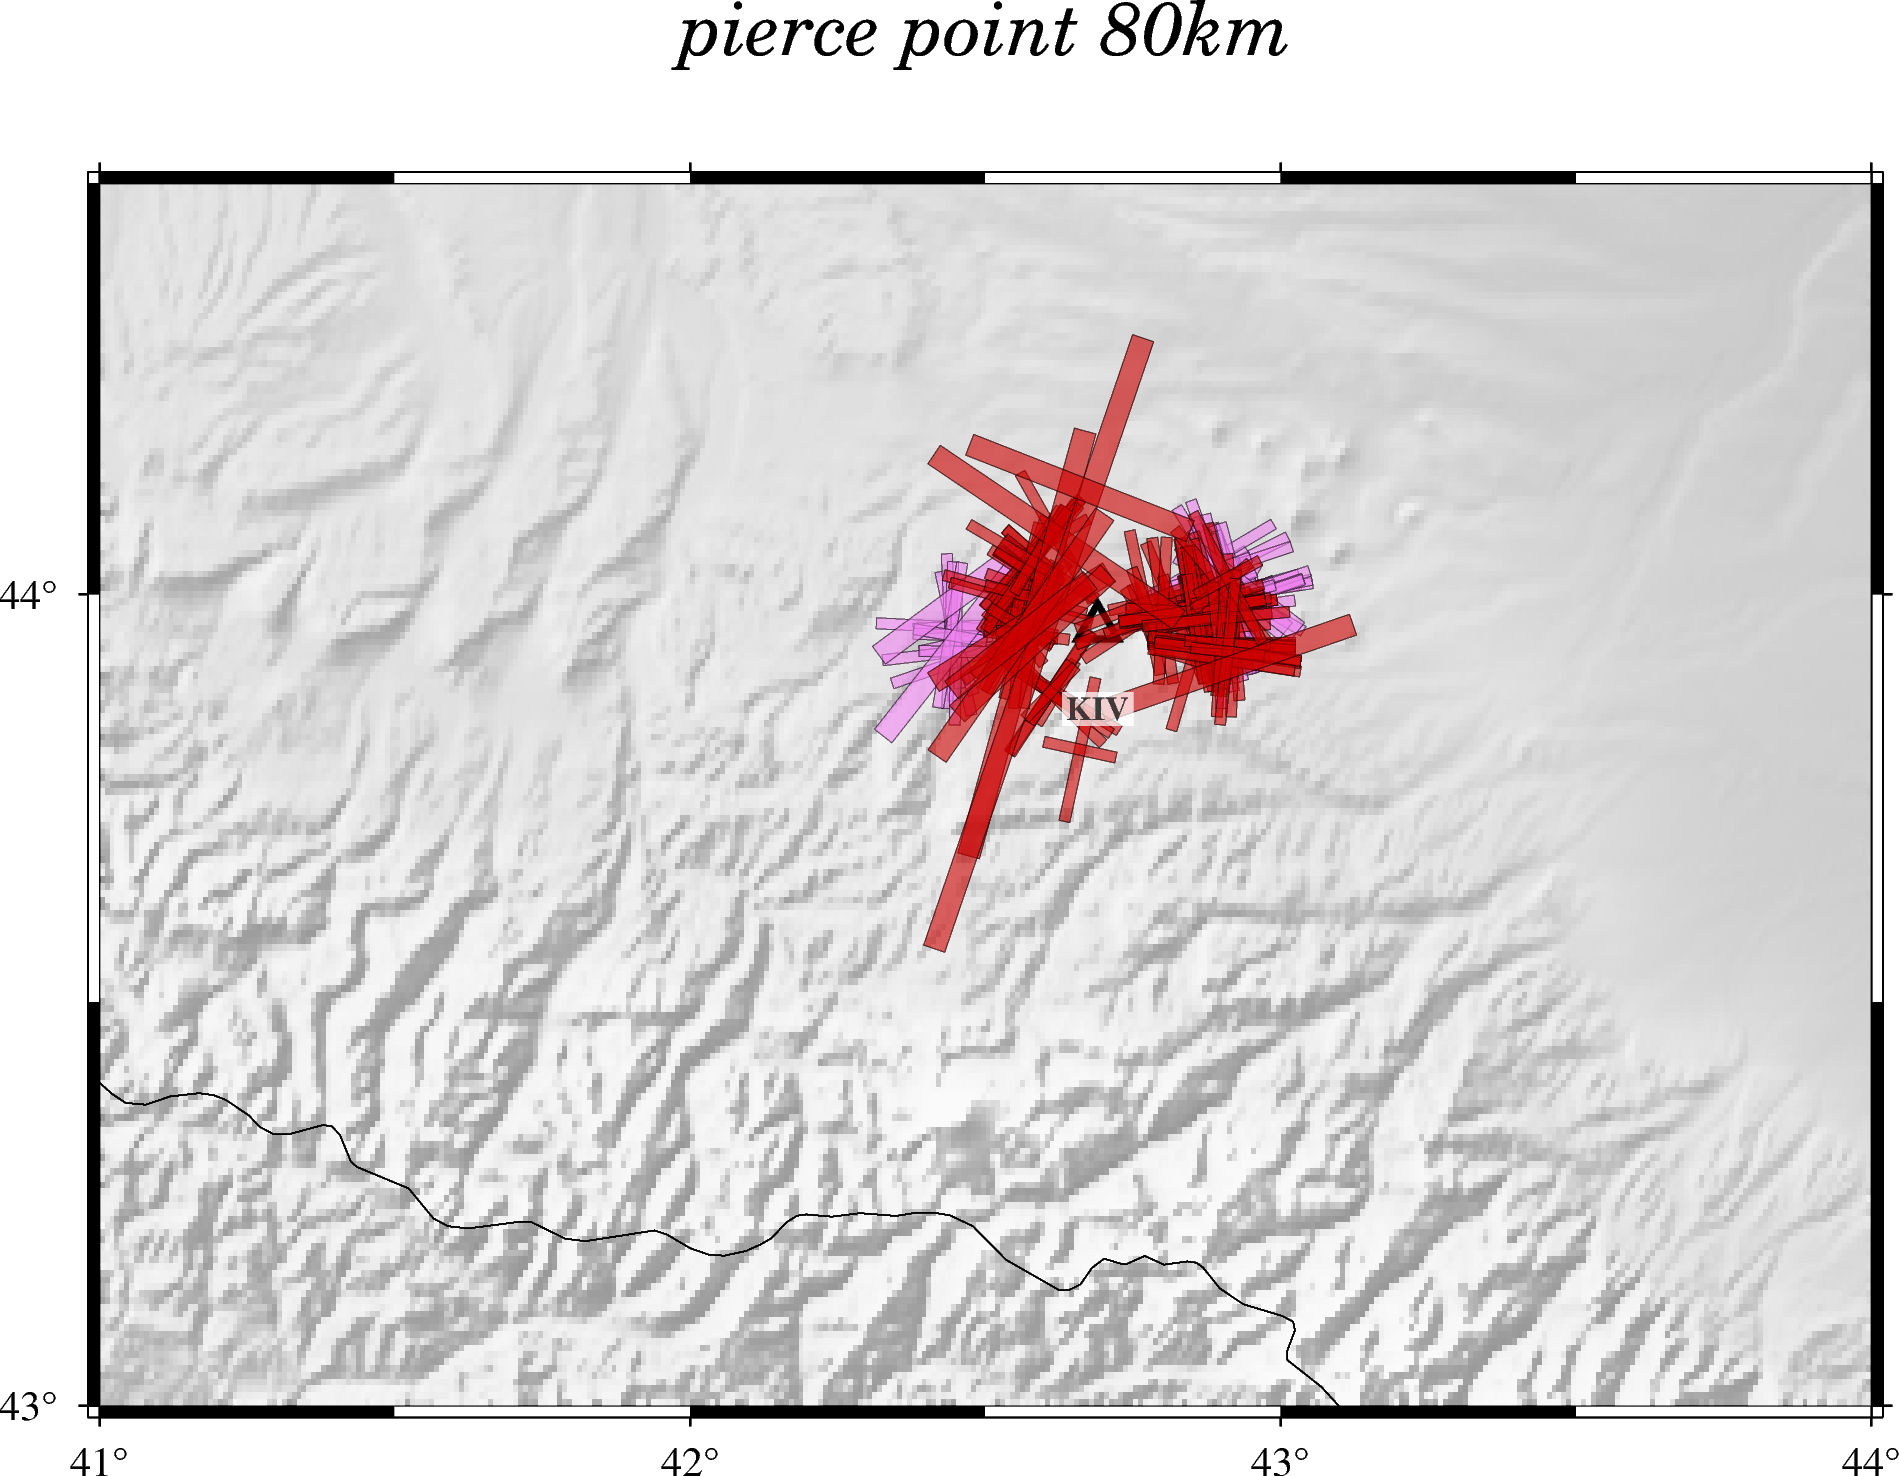

==================II.KIV==================
KIV 20140326_032936
KIV 20170926_042000
KIV 20181223_230843


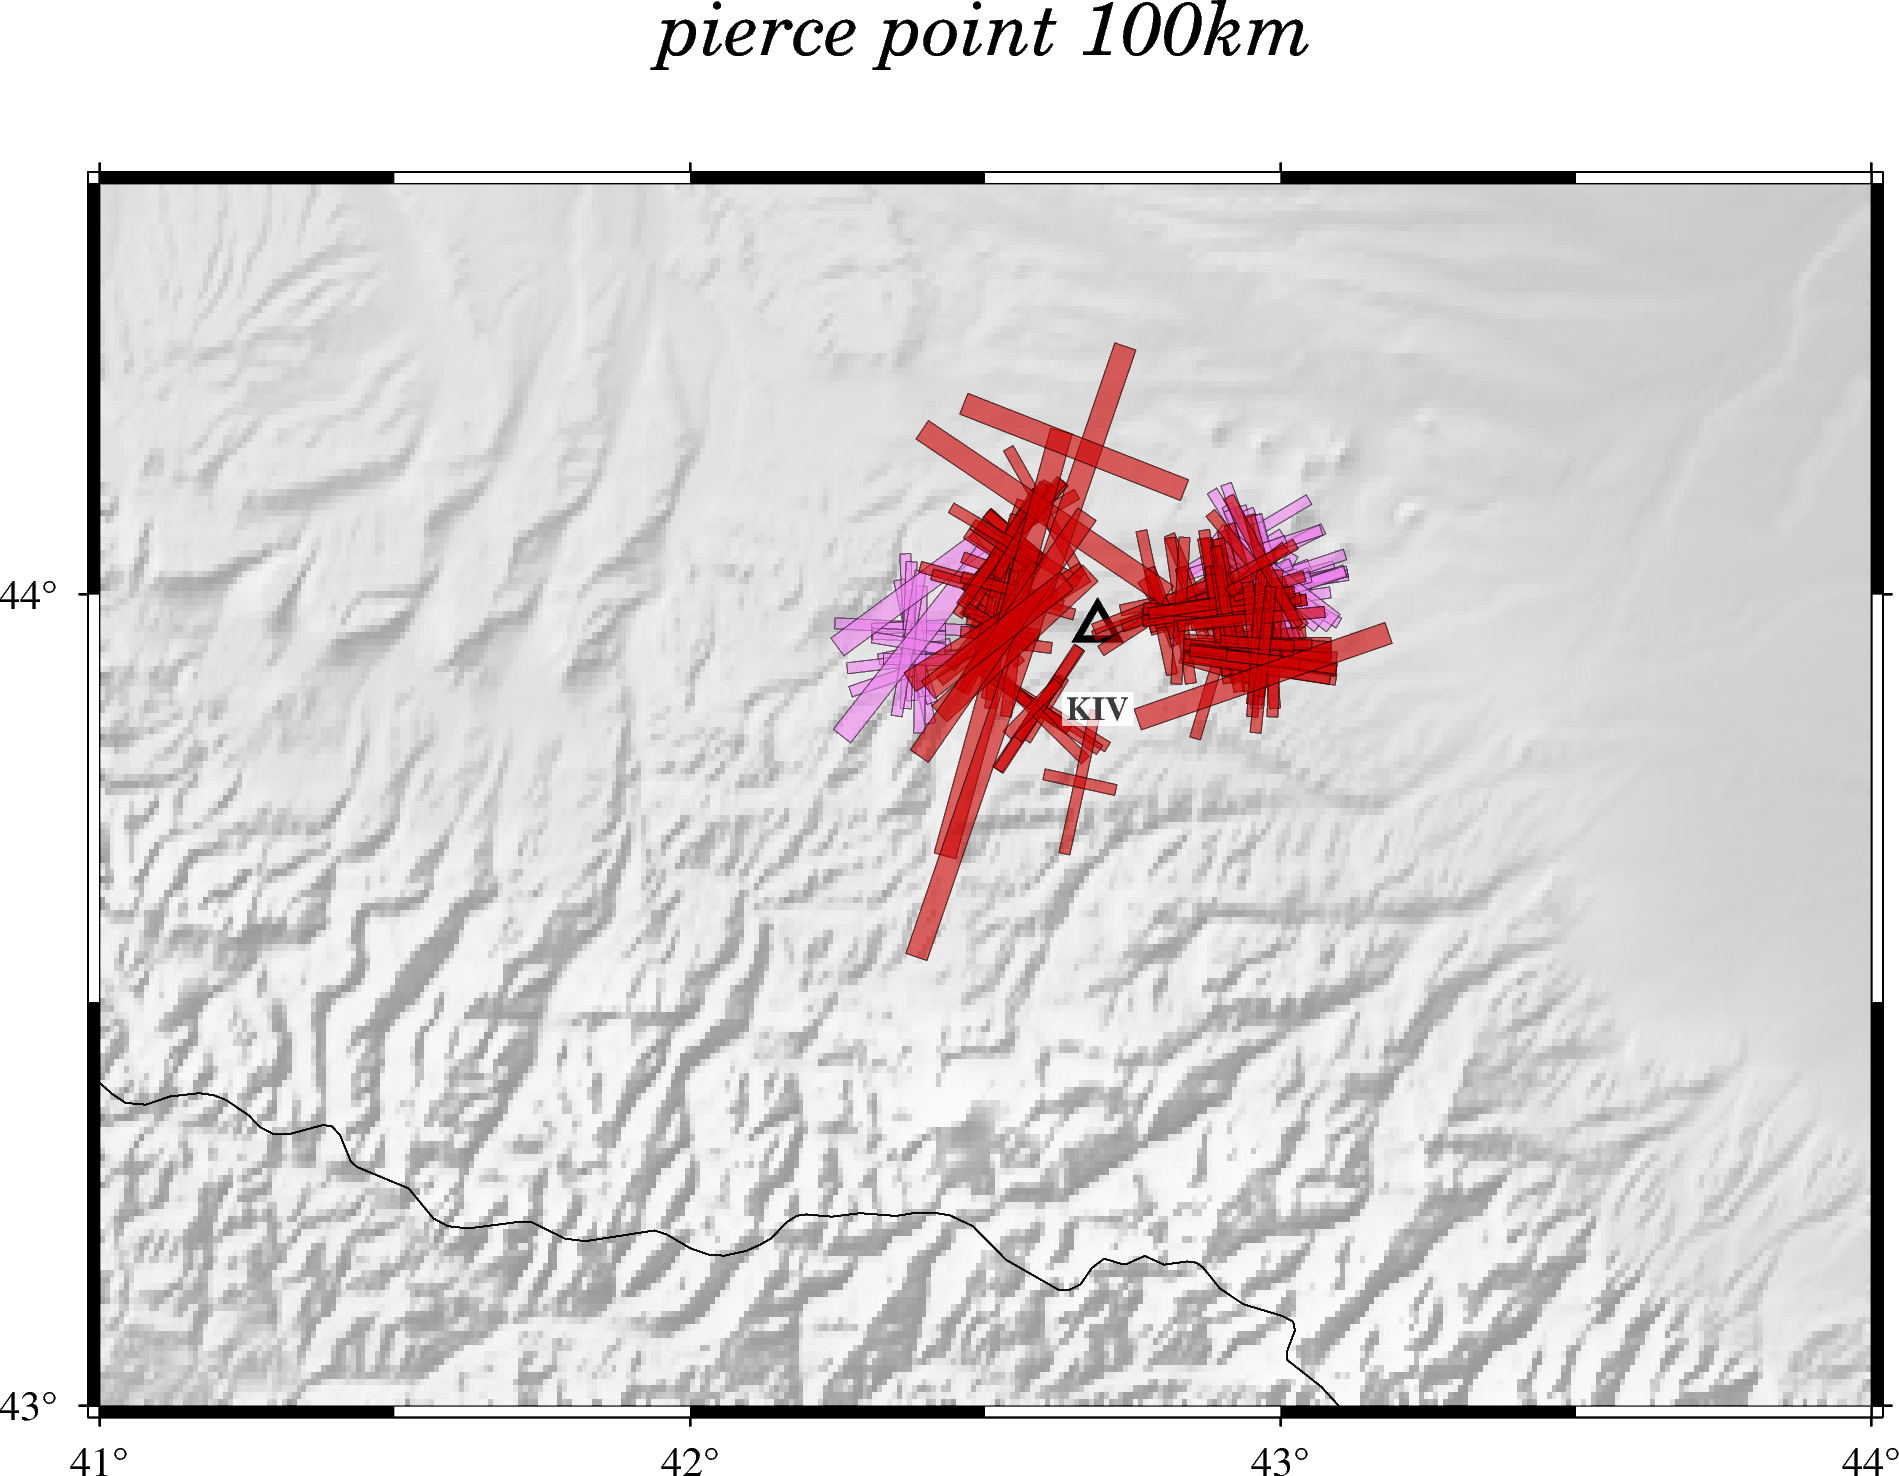

==================II.KIV==================
KIV 20140326_032936
KIV 20170926_042000
KIV 20181223_230843


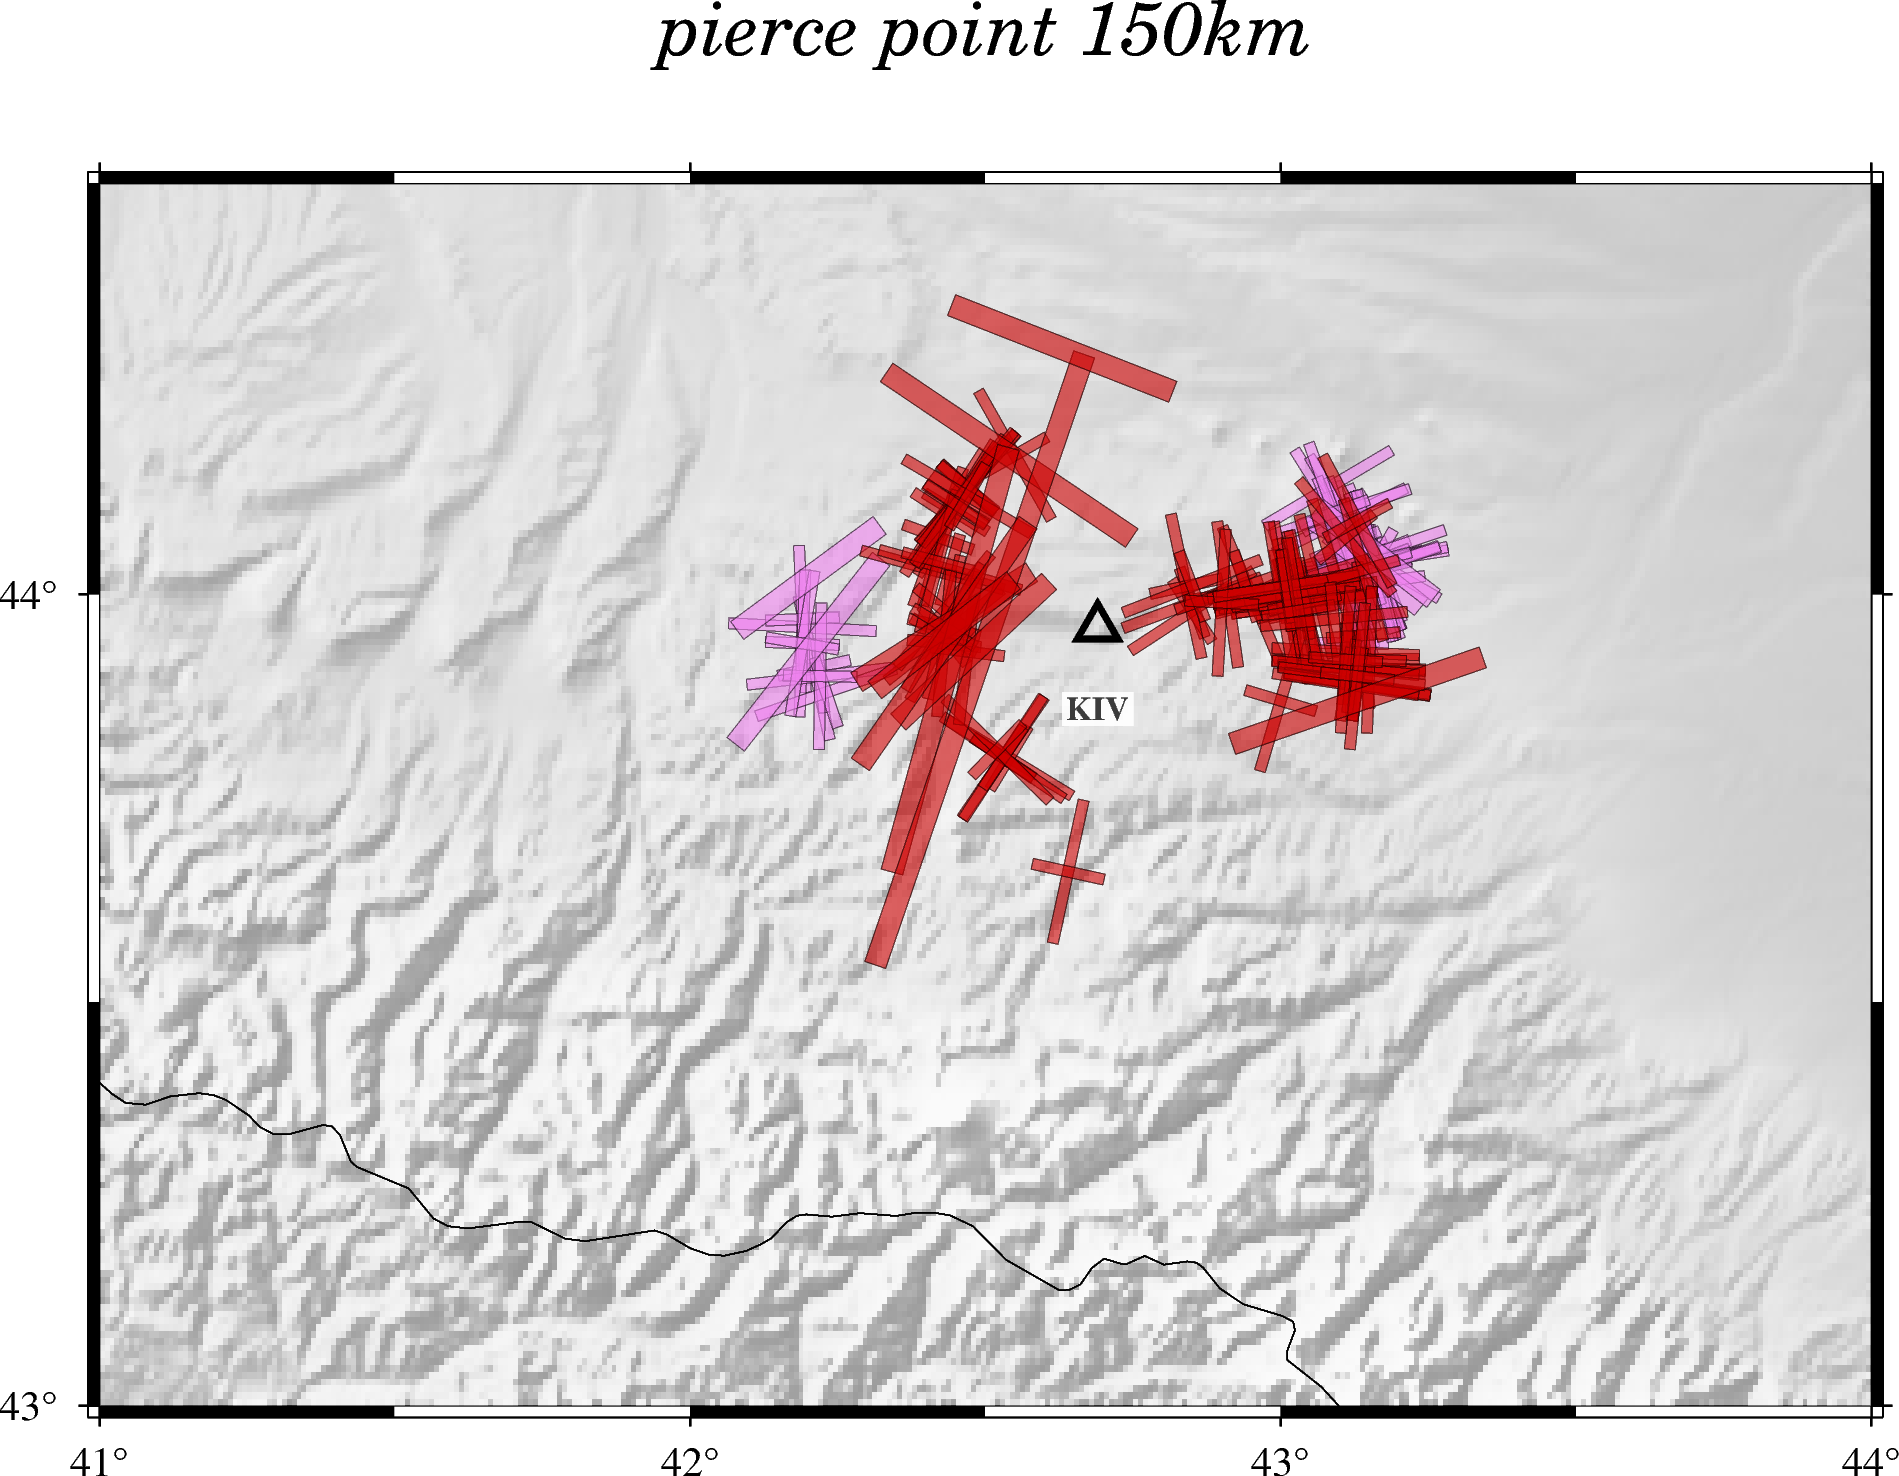

==================II.KIV==================
KIV 20140326_032936
KIV 20170926_042000
KIV 20181223_230843


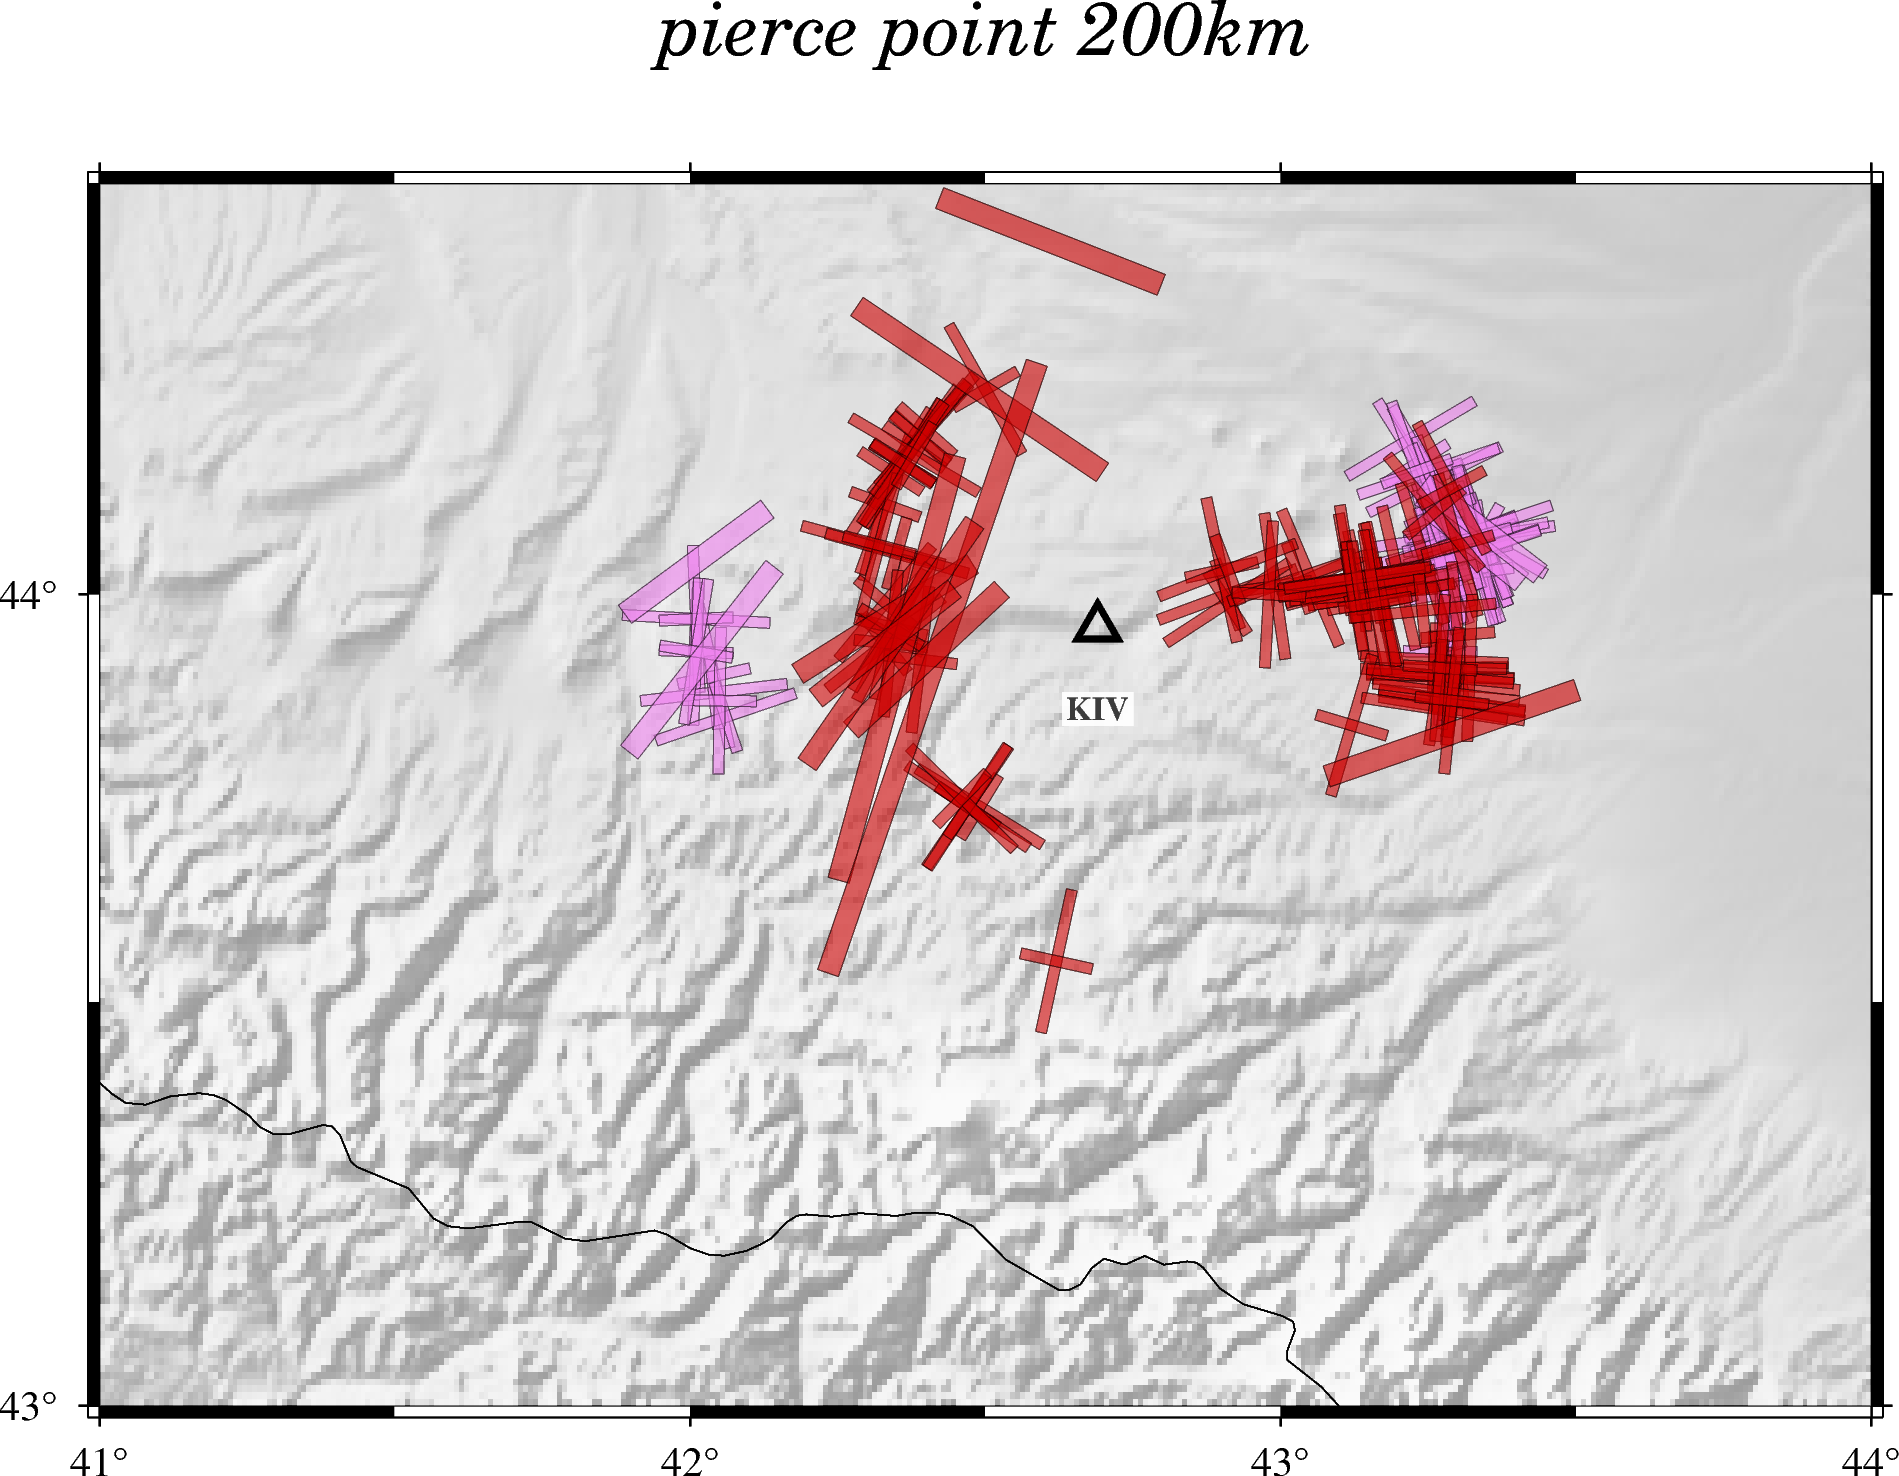

In [19]:
# region = [40, 47, 39.5, 44.5] original
# region = [42, 47, 38.5, 42] ## for AM
# region = [40.5, 47, 40.5, 43.5] ## for GO
region = [41, 44, 43, 44.5] ## for KIV

fig = 'AM'

for PierceDep in [80, 100, 150, 200]:

    for NET in ['II']: #'AM','IU','KO','AB']:

        
        for pkl in sorted(glob.glob(f'{PKLpath}/{NET}*.pkl')):
            STApkl = pickle.load(open(pkl, "rb"))
            values = [value for keys, value in STApkl.items() ][0]
            net = values['network']; sta = values['station']
            stlat = values['latitude']; stlon = values['longitude']
           
            figmap = pygmt.Figure()
            title = f"pierce point {PierceDep}km"
            PygmtBegin(figmap,region,title)
            figmap.plot(x=stlon, y=stlat, style="t0.4c", pen="1.5p,black")
            print(f'=================={net}.{sta}==================')

            for resultpath in sorted(glob.glob(f'{path}/2010-2020_*_classify/{net}.{sta}*csv')):
                df = pd.read_csv(resultpath)
                
                dff = df[df['Null']==True][df['Quality']=='Good'][df['Pick']==True]
                for i in range(len(dff)):
                    event = dff['Event'].values[i]
                    evlat = dff['Ev_lat'].values[i]
                    evlon = dff['Ev_lon'].values[i]
                    evdep = dff['Depth'].values[i]
                    phase = dff['Phase'].values[i]

                    if method == 'SC': 
                        phi = dff['SCPhi'].values[i]
                        dt  = 0.5  ## due to null, the value isn't meaningful
                        if phase == 'SKS': color = 'red3'
                        elif phase == 'SKKS': color = 'violet'
                    elif method == 'RC': 
                        phi = dff['RCPhi'].values[i]
                        dt  = dff['RCdt'].values[i]          
                        if phase == 'SKS': color = 'deepskyblue1'
                        elif phase == 'SKKS': color = 'skyblue'            


                    p_lon, p_lat = PiercePoint(evdep, stlat, stlon, evlat, evlon, phase, PierceDep)
                    data = [[p_lon, p_lat, phi-90, 1.5, dt*40],[p_lon, p_lat, phi, 1.5, dt*20]]
                    figmap.plot(data=data, style="J", color=color, pen="0.1p,black",transparency=40)
                
                dfff = df[df['Null']==False][df['Quality']!='Poor'][df['Pick']==True]
                for i in range(len(dfff)):
                    event = dfff['Event'].values[i]
                    evlat = dfff['Ev_lat'].values[i]
                    evlon = dfff['Ev_lon'].values[i]
                    evdep = dfff['Depth'].values[i]
                    phase = dfff['Phase'].values[i]
                    if sta in dr['station'].to_list() and event in dr['time'].to_list():
                            print(f'{sta} {event}')
                    else:
                        if method == 'SC': 
                            phi = dfff['SCPhi'].values[i]
                            dt  = dfff['SCdt'].values[i]
                            if phase == 'SKS': color = 'red3'
                            elif phase == 'SKKS': color = 'violet'
                        elif method == 'RC': 
                            phi = dfff['RCPhi'].values[i]
                            dt  = dfff['RCdt'].values[i]          
                            if phase == 'SKS': color = 'deepskyblue1'
                            elif phase == 'SKKS': color = 'skyblue'            


                        p_lon, p_lat = PiercePoint(evdep, stlat, stlon, evlat, evlon, phase, PierceDep)
                        data = [[p_lon, p_lat, phi-90, 3, dt*40]]
                        figmap.plot(data=data, style="J", color=color, pen="0.02p,black",transparency=40)
                figmap.text(x=stlon,y=stlat-0.1,text=sta, font="8p,Times-Bold,black",fill='white',transparency=30)

            print('-------end')
            figmap.show()
#     figmap.savefig(f'{figpath}/null/{fig}_{PierceDep}km.pdf')
#     figmap.savefig(f'{figpath}/null/{fig}_{PierceDep}km.png', dpi=200)

            

        